# 0. Initialization & Dependencies

In [108]:
import json
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.tree import DecisionTreeRegressor

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)

# 1. Data Loading & Initial Preparation

In [109]:
# Load data
df = pd.read_csv("../dataset/processed/Southern_Vietnam_Weather_processed.csv")
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values(['name', 'datetime'])

# 2. Target Creation

In [110]:
# Create Target Column
# Predict Tempmax_C of Tomorrow
df['target'] = df.groupby('name')['tempmax_C'].shift(-1)
df = df.dropna(subset=['target']).reset_index(drop=True)
TARGET = 'target'

# 3. Temporal Train/Validation/Test Split (Gap-Aware)

In [111]:
#    Split Train / Val / Test with GAP
#    - Test: 12 tháng cuối (tính theo EFFECTIVE_MAX = max_date - 1 ngày)
#    - Val : 6 tháng liền trước Test, chừa GAP 30 ngày
#    - Train: phần còn lại, chừa GAP 30 ngày trước Val

max_date = df['datetime'].max()                                # ví dụ 2025-09-01
EFFECTIVE_MAX = max_date - pd.Timedelta(days=1)                # 2025-08-31 (do shift -1)
TEST_END   = EFFECTIVE_MAX
TEST_START = TEST_END - pd.DateOffset(years=1) + pd.Timedelta(days=1)   # 12 tháng

GAP_DAYS = 30

VAL_END   = TEST_START - pd.Timedelta(days=GAP_DAYS) - pd.Timedelta(days=1)
VAL_START = VAL_END   - pd.DateOffset(months=6) + pd.Timedelta(days=1)  # 6 tháng

TRAIN_START = df['datetime'].min()
TRAIN_END   = VAL_START - pd.Timedelta(days=GAP_DAYS) - pd.Timedelta(days=1)

# Masks
train_mask = (df['datetime'] >= TRAIN_START) & (df['datetime'] <= TRAIN_END)
val_mask   = (df['datetime'] >= VAL_START)   & (df['datetime'] <= VAL_END)
test_mask  = (df['datetime'] >= TEST_START)  & (df['datetime'] <= TEST_END)

# Kiểm tra không giao nhau
assert not (train_mask & val_mask).any()
assert not (train_mask & test_mask).any()
assert not (val_mask   & test_mask).any()

# (Tuỳ chọn) In thông tin khoảng thời gian
print("TRAIN:", df.loc[train_mask, 'datetime'].min().date(), "→", df.loc[train_mask, 'datetime'].max().date())
print("VAL  :", df.loc[val_mask,   'datetime'].min().date(), "→", df.loc[val_mask,   'datetime'].max().date())
print("TEST :", df.loc[test_mask,  'datetime'].min().date(), "→", df.loc[test_mask,  'datetime'].max().date())


# Tạo X/y cho từng tập
X_all = df.drop(columns=[TARGET])
y_all = df[TARGET]

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]


TRAIN: 2015-01-01 → 2024-01-01
VAL  : 2024-02-01 → 2024-07-31
TEST : 2024-08-31 → 2025-08-30


# 4. Baseline Preprocessing — “Raw” Design Matrix

In [112]:
# Bỏ datetime khỏi num_cols 
cat_cols = ['name']
num_cols = [c for c in X_train.columns if c not in cat_cols and c not in ['datetime', 'tempmax_C']]

all_provinces = sorted(df['name'].dropna().unique())
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop= None, handle_unknown='ignore', sparse_output=False, categories=[all_provinces]), cat_cols),
        ('num', 'passthrough', num_cols), 
    ],
    remainder='drop'
)

raw_pipeline = Pipeline([('preprocess', preprocess)])

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test  = raw_pipeline.transform(X_test)

feature_names = raw_pipeline.named_steps['preprocess'].get_feature_names_out()
X_raw_train_df = pd.DataFrame(X_raw_train, columns=feature_names, index=X_train.index)
X_raw_val_df = pd.DataFrame(X_raw_val, columns=feature_names, index=X_val.index)
X_raw_test_df  = pd.DataFrame(X_raw_test,  columns=feature_names, index=X_test.index)

## Save ouput

In [113]:
out_dir = Path('../dataset/processed') / "splits" 
out_dir.mkdir(parents=True, exist_ok=True)
pd.concat([X_raw_train_df, y_train.rename(TARGET)],
            axis=1).to_csv(out_dir / 'raw_train.csv', index=False)
            
pd.concat([X_raw_val_df, y_val.rename(TARGET)],
            axis=1).to_csv(out_dir / 'raw_val.csv', index=False)

pd.concat([X_raw_test_df, y_test.rename(TARGET)],
            axis=1).to_csv(out_dir / 'raw_test.csv', index=False)


display(X_raw_train_df)

,cat__name_An Giang,cat__name_Bình Dương,cat__name_Bình Phước,cat__name_Bạc Liêu,cat__name_Bến Tre,cat__name_Cà Mau,cat__name_Cần Thơ,cat__name_Hậu Giang,cat__name_Hồ Chí Minh,cat__name_Kiên Giang,...,num__uvindex,num__tempmin_C,num__temp_C,num__feelslikemax_C,num__feelslike_C,num__year,num__month,num__day_of_year,num__day_of_week,num__quarter
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,22.06,25.11,29.72,25.61,2015.0,1.0,1.0,3.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,20.06,23.72,26.06,23.72,2015.0,1.0,2.0,4.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,22.83,25.33,30.89,25.78,2015.0,1.0,3.0,5.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,22.06,26.22,33.39,27.44,2015.0,1.0,4.0,6.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,24.06,26.28,33.39,27.50,2015.0,1.0,5.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,24.94,27.56,38.00,30.28,2023.0,12.0,362.0,3.0,4.0
69516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,25.28,28.17,40.61,31.61,2023.0,12.0,363.0,4.0,4.0
69517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,25.44,28.50,39.22,31.78,2023.0,12.0,364.0,5.0,4.0
69518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,24.22,27.56,38.61,31.06,2023.0,12.0,365.0,6.0,4.0


# 5. Model-Based Feature Selection on Raw Data(Decision Tree)

In [114]:
# Using Decision Tree to select Features
dt_feature_selection_pipeline  = Pipeline([
    ('preprocess', preprocess),
    ('decision_tree', DecisionTreeRegressor(random_state=42))
])

dt_feature_selection_pipeline.fit(X_train, y_train)
feature_importance_series = pd.Series(
    dt_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=feature_names
)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
display(sorted_feature_importances[:10])

num__temp_C              0.491112
num__humidity            0.072469
num__day_of_year         0.057194
num__feelslikemax_C      0.052745
num__winddir             0.047274
num__solarradiation      0.047193
num__sealevelpressure    0.044002
num__cloudcover          0.035056
num__month               0.027560
num__tempmin_C           0.025068
dtype: float64

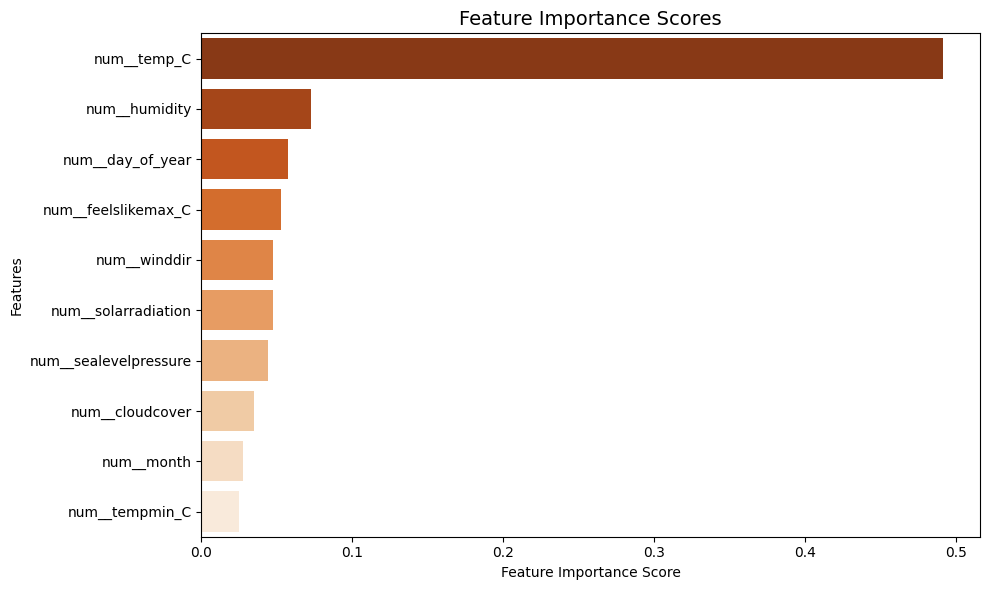

In [115]:
# Lấy top-10 đặc trưng 
top_k = 10
s = sorted_feature_importances.head(top_k)

# Vẽ barplot theo chiều ngang
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=s.values, 
    y=s.index,
    hue=s.index,
    palette="Oranges_r", 
    legend=False     
)


ax.set_title("Feature Importance Scores", fontsize=14)
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")

plt.tight_layout()
plt.show()

In [116]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(dt_feature_selection_pipeline.named_steps['decision_tree'],
                           threshold="median", prefit=True)

# Dựng lại DF từ đúng transform đã dùng cho selector
X_train_pre = dt_feature_selection_pipeline.named_steps['preprocess'].transform(X_train)
X_val_pre   = dt_feature_selection_pipeline.named_steps['preprocess'].transform(X_val)
X_test_pre  = dt_feature_selection_pipeline.named_steps['preprocess'].transform(X_test)

X_train_sel = selector.transform(X_train_pre)
X_val_sel   = selector.transform(X_val_pre)
X_test_sel  = selector.transform(X_test_pre)

selected_features = feature_names[selector.get_support()]

X_dt_train = pd.DataFrame(X_train_sel, columns=selected_features, index=X_train.index)
X_dt_val   = pd.DataFrame(X_val_sel,   columns=selected_features, index=X_val.index)
X_dt_test  = pd.DataFrame(X_test_sel,  columns=selected_features, index=X_test.index)

print("Number of features before selection:", len(feature_names))
print("Number of features after selection:", X_dt_train.shape[1]) # Some provinces will be removed

Number of features before selection: 34
Number of features after selection: 17


## Save output

In [117]:
pd.concat([X_dt_train, y_train.rename(TARGET)], axis=1).to_csv(out_dir / 'dt_train.csv', index=False)
pd.concat([X_dt_val, y_val.rename(TARGET)], axis=1).to_csv(out_dir / 'dt_val.csv', index=False)
pd.concat([X_dt_test, y_test.rename(TARGET)], axis=1).to_csv(out_dir / 'dt_test.csv', index=False)

# 6. Leakage-Free Temporal Feature Engineering

In [118]:
def add_new_features_func(df):
    df = df.copy()
    assert np.issubdtype(df['datetime'].dtype, np.dtype('datetime64[ns]').type), \
        "datetime must be datetime64[ns]"
    df = df.sort_values(['name', 'datetime'])
    g = df.groupby('name', group_keys=False)

    # Lags
    for lag in [1, 2, 3, 4]:
        df[f'tempmax_C_lag{lag}'] = g['tempmax_C'].shift(lag)

    for lag in [1, 2]:
        df[f'humidity_lag_{lag}'] = g['humidity'].shift(lag)
        df[f'cloudcover_lag_{lag}'] = g['cloudcover'].shift(lag)
    # Rolling means (quá khứ thuần túy: dùng dữ liệu tới ngày t-1)
    df['tempmax_C_rollmean7'] = g['tempmax_C'].transform(
        lambda s: s.shift(1).rolling(7, min_periods=7).mean()
    )
    df['tempmax_C_rollmean3'] = g['tempmax_C'].transform(
        lambda s: s.shift(1).rolling(3, min_periods=3).mean()
    )
    df['tempmax_C_rollstd7'] = g['tempmax_C'].transform(
        lambda s: s.shift(1).rolling(7, min_periods=7).std()
    )
    # Seasonality (sin/cos)
    month     = df['datetime'].dt.month
    dayofyear = df['datetime'].dt.dayofyear
    df['month_sin'] = np.sin(2 * np.pi * month / 12)
    df['month_cos'] = np.cos(2 * np.pi * month / 12)
    df['doy_sin']   = np.sin(2 * np.pi * dayofyear / 365.25)
    df['doy_cos']   = np.cos(2 * np.pi * dayofyear / 365.25)

    return df

In [119]:
class AddNewFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, dropna=True):
        self.dropna = dropna

    def fit(self, X, y=None):
        self.columns_ = X.columns
        X_tmp = add_new_features_func(X.copy())
        if self.dropna:
            X_tmp = X_tmp.dropna()
        self.new_features_ = [c for c in X_tmp.columns if c not in self.columns_]
        return self
    
    def transform(self, X):
        X_out = add_new_features_func(X.copy())
        if self.dropna:
            X_out = X_out.dropna()
        return X_out
    
    def get_feature_names_out(self, input_features=None):
        return list(self.columns_) + self.new_features_

# 7. End-to-End Feature Engineering Pipeline

In [120]:
gen_num = [
    'tempmax_C_lag1', 'tempmax_C_lag2', 'tempmax_C_lag3', 'tempmax_C_lag4',
    'tempmax_C_rollmean7', 'tempmax_C_rollmean3', 'tempmax_C_rollstd7',
    'month_sin', 'month_cos',    
    'doy_sin', 'doy_cos'         
]

all_nums = [c for c in num_cols] + gen_num
all_cats = cat_cols

num_proc = Pipeline([
    ('sc', 'passthrough')
])

cat_proc = Pipeline([
    ('ohe', OneHotEncoder(drop=None, handle_unknown='ignore', sparse_output=False, categories=[all_provinces]))
])

fe_preprocess = ColumnTransformer([
    ('num', num_proc, all_nums),
    ('cat', cat_proc, all_cats),
], verbose_feature_names_out=False).set_output(transform='pandas')

fe_pipeline = Pipeline([
    ('add', AddNewFeaturesTransformer(dropna=True)),
    ('fe_preprocess', fe_preprocess)
]).set_output(transform='pandas')

In [121]:
# Transform with Pipeline
Xt_tr = fe_pipeline.fit_transform(X_train, y_train)
Xt_va = fe_pipeline.transform(X_val)
Xt_te = fe_pipeline.transform(X_test)

# Align y with Xt
y_tr_aligned = y_train.loc[Xt_tr.index]
y_va_aligned = y_val.loc[Xt_va.index]
y_te_aligned = y_test.loc[Xt_te.index]

# Drop constant columns
nz_cols = Xt_tr.columns[Xt_tr.nunique(dropna=False) > 1]
Xt_tr = Xt_tr[nz_cols]
Xt_va = Xt_va[nz_cols]
Xt_te  = Xt_te[nz_cols]

print('Train shape after feature engineering & dropping NaN:', Xt_tr.shape)

Train shape after feature engineering & dropping NaN: (59058, 45)


In [122]:
# Prevent Leakage -> remove tempmax_C after adding lags/rolling features
Xt_tr = Xt_tr.drop(columns=['tempmax_C'], errors='ignore')
Xt_va = Xt_va.drop(columns=['tempmax_C'], errors='ignore')
Xt_te = Xt_te.drop(columns=['tempmax_C'], errors='ignore')

# 8. Mutual Information Screening

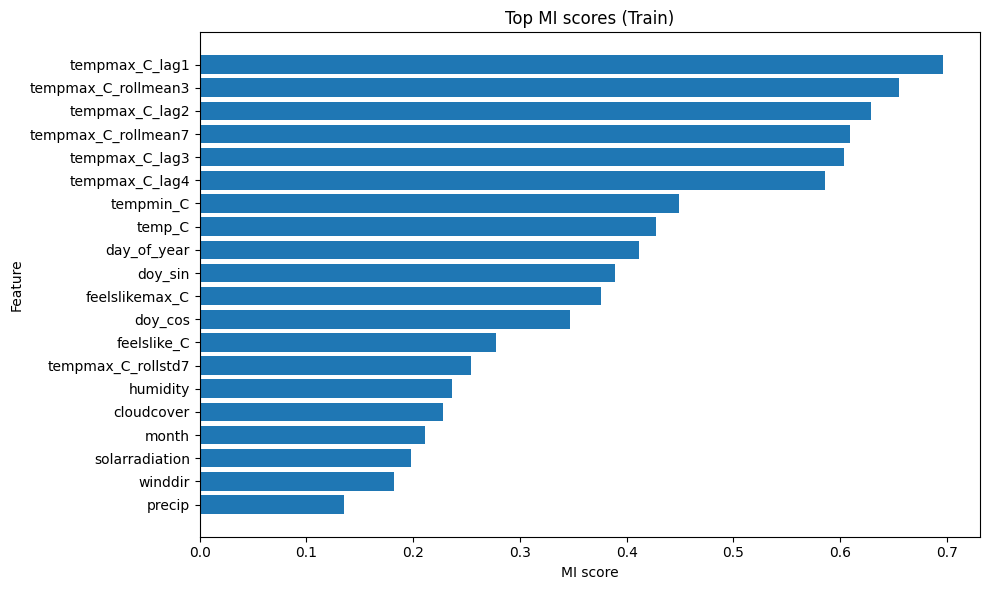

In [123]:
from sklearn.feature_selection import mutual_info_regression

ohe = fe_pipeline.named_steps['fe_preprocess'].named_transformers_['cat'].named_steps['ohe']
cat_names = set(ohe.get_feature_names_out(all_cats)) & set(Xt_tr.columns)
is_discrete = np.array([c in cat_names for c in Xt_tr.columns], dtype=bool)

mi = mutual_info_regression(
    Xt_tr,                      
    y_tr_aligned.values.ravel(),
    discrete_features=is_discrete,
    random_state=42
)

mi_series = pd.Series(mi, index=Xt_tr.columns).sort_values(ascending=False)

# Vẽ Top-N
N = min(20, len(mi_series))
topN = mi_series.head(N).iloc[::-1]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(topN.index, topN.values)
plt.title("Top MI scores (Train)")
plt.xlabel("MI score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('../figures/top_mi_score.png', bbox_inches='tight')
plt.show()

## Save output

In [124]:
K = df.columns.drop('target').shape[0]
topk_cols = list(mi_series.head(K).index)
fe_tr = Xt_tr[topk_cols].assign(target=y_tr_aligned.values)
fe_va = Xt_va[topk_cols].assign(target=y_va_aligned.values)
fe_te = Xt_te[topk_cols].assign(target=y_te_aligned.values)

# Save File
fe_tr.to_csv(out_dir / 'fe_train.csv', index=False)
fe_va.to_csv(out_dir / 'fe_val.csv', index=False)
fe_te.to_csv(out_dir / 'fe_test.csv', index=False)

display(pd.Series(topk_cols, name='fe_topk_features').reset_index(drop=True))

0          tempmax_C_lag1
1     tempmax_C_rollmean3
2          tempmax_C_lag2
3     tempmax_C_rollmean7
4          tempmax_C_lag3
5          tempmax_C_lag4
6               tempmin_C
7                  temp_C
8             day_of_year
9                 doy_sin
10         feelslikemax_C
11                doy_cos
12            feelslike_C
13     tempmax_C_rollstd7
14               humidity
15             cloudcover
16                  month
17         solarradiation
18                winddir
Name: fe_topk_features, dtype: object

# 9. Decision Tree Feature Selection on FE Data

In [125]:
# FE transform trước để align X và y
Xt_tr = fe_pipeline.fit_transform(X_train, y_train)
Xt_va = fe_pipeline.transform(X_val)
Xt_te = fe_pipeline.transform(X_test)

# Align y theo index của Xt_*
y_tr_aligned = y_train.loc[Xt_tr.index]
y_va_aligned = y_val.loc[Xt_va.index]
y_te_aligned = y_test.loc[Xt_te.index]

print("Shape sau FE:", Xt_tr.shape, y_tr_aligned.shape)

Shape sau FE: (59058, 45) (59058,)


In [126]:
# Fit Decision Tree trực tiếp trên dữ liệu sau FE
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(Xt_tr, y_tr_aligned)

# Lấy tên cột sau FE
pipeline_feature_names = fe_pipeline.get_feature_names_out()

# Tính và hiển thị feature importance
feature_importance_series = pd.Series(
    dt_model.feature_importances_,
    index=pipeline_feature_names
).sort_values(ascending=False)

display(feature_importance_series[:10])

tempmax_C_rollmean3    0.418741
temp_C                 0.168248
feelslikemax_C         0.029213
sealevelpressure       0.028523
winddir                0.028189
cloudcover             0.027480
solarradiation         0.025938
doy_sin                0.025880
humidity               0.025148
tempmax_C_rollmean7    0.024534
dtype: float64

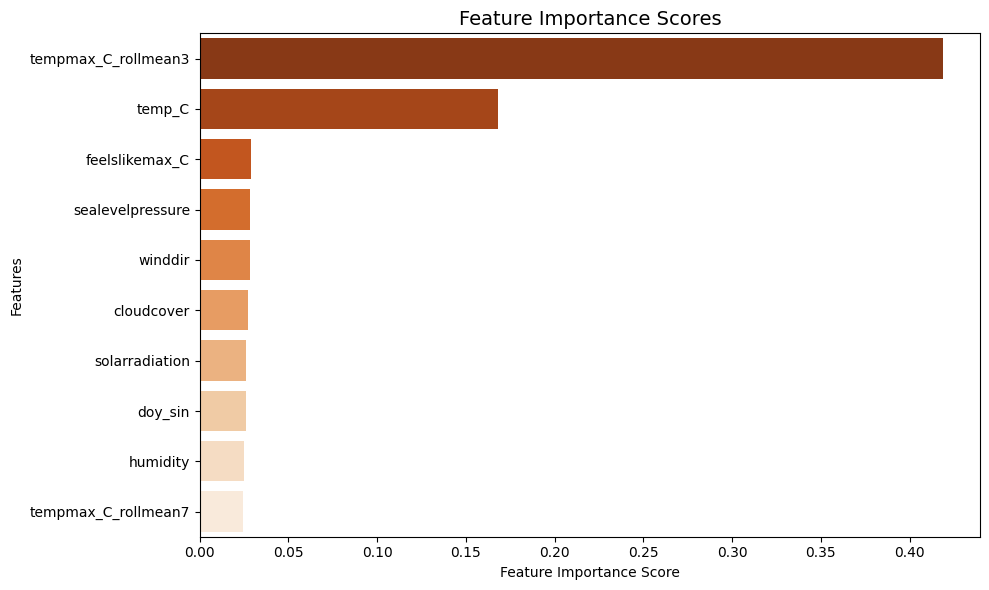

In [127]:
# Lấy top-k đặc trưng (ví dụ 10)
top_k = 10
s = feature_importance_series.head(top_k)

# Vẽ barplot theo chiều ngang
plt.figure(figsize=(10,6))
ax = sns.barplot(x=s.values, y=s.index, hue=s.index, palette='Oranges_r', legend=False)


ax.set_title("Feature Importance Scores", fontsize=14)
ax.set_xlabel("Feature Importance Score")
ax.set_ylabel("Features")

plt.tight_layout()
plt.show()

In [128]:
# Áp dụng SelectFromModel
selector = SelectFromModel(
    dt_model,               
    threshold="median",     
    prefit=True              
)

# Biến đổi X theo selector
Xt_tr_sel = selector.transform(Xt_tr)
Xt_va_sel = selector.transform(Xt_va)
Xt_te_sel = selector.transform(Xt_te)

# Lấy tên các feature được giữ lại
selected_features = fe_pipeline.get_feature_names_out()[selector.get_support()]

print("Number of Features before selection :", Xt_tr.shape[1])
print("Number of Features after selection    :", Xt_tr_sel.shape[1])

# 6) Tạo DataFrame với các feature đã chọn + target
X_fe_dt_train = pd.DataFrame(Xt_tr_sel, columns=selected_features, index=Xt_tr.index)\
                  #.assign(target=y_tr_aligned.values)

X_fe_dt_val   = pd.DataFrame(Xt_va_sel, columns=selected_features, index=Xt_va.index)\
                  #.assign(target=y_va_aligned.values)

X_fe_dt_test  = pd.DataFrame(Xt_te_sel, columns=selected_features, index=Xt_te.index)\
                  #.assign(target=y_te_aligned.values)

display(X_fe_dt_train.head())

Number of Features before selection : 45
Number of Features after selection    : 23


/Users/jky/Library/CloudStorage/GoogleDrive-lethanhquang094@gmail.com/My Drive/FPT/Semester_3/ADY201m/ADY201m_Proj/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/jky/Library/CloudStorage/GoogleDrive-lethanhquang094@gmail.com/My Drive/FPT/Semester_3/ADY201m/ADY201m_Proj/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/jky/Library/CloudStorage/GoogleDrive-lethanhquang094@gmail.com/My Drive/FPT/Semester_3/ADY201m/ADY201m_Proj/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


,humidity,precip,winddir,sealevelpressure,cloudcover,solarradiation,tempmin_C,temp_C,feelslikemax_C,feelslike_C,...,tempmax_C_lag1,tempmax_C_lag2,tempmax_C_lag3,tempmax_C_lag4,tempmax_C_rollmean7,tempmax_C_rollmean3,tempmax_C_rollstd7,month_sin,doy_sin,doy_cos
7,76.1,0.004,102.1,1011.8,64.9,202.1,24.06,26.78,33.39,28.06,...,30.06,31.06,30.06,30.06,29.202857,30.393333,1.676163,0.5,0.137185,0.990545
8,72.9,0.205,93.7,1012.4,55.2,224.0,23.67,26.61,32.50,27.44,...,30.06,30.06,31.06,30.06,29.488571,30.393333,1.618347,0.5,0.154204,0.988039
9,75.3,0.000,78.1,1011.7,60.4,209.5,23.06,26.67,33.33,27.83,...,31.06,30.06,30.06,31.06,30.202857,30.393333,0.690066,0.5,0.171177,0.985240
10,80.0,0.000,104.4,1011.5,67.8,222.3,22.06,26.39,32.67,27.72,...,31.06,31.06,30.06,30.06,30.488571,30.726667,0.534522,0.5,0.188099,0.982150
11,80.0,0.000,57.7,1011.7,63.4,203.0,22.06,25.89,32.67,26.72,...,30.06,31.06,31.06,30.06,30.488571,30.726667,0.534522,0.5,0.204966,0.978769


## Save output

In [129]:
pd.concat([X_fe_dt_train, y_tr_aligned.rename(TARGET)], axis=1)\
  .to_csv(out_dir / 'fe_dt_train.csv', index=False)

pd.concat([X_fe_dt_val, y_va_aligned.rename(TARGET)], axis=1)\
  .to_csv(out_dir / 'fe_dt_val.csv', index=False)

pd.concat([X_fe_dt_test, y_te_aligned.rename(TARGET)], axis=1)\
  .to_csv(out_dir / 'fe_dt_test.csv', index=False)